# Data Analysis Phase
In this notebook I'm implementing the data analysis phase of our regression modeling problem.

**Author**: Arthur G.
***

## Loading Dependencies
In this section I'm loading all the dependencies needed for the data analysis phase.

In [1]:
# custom functions (from src)
import sys
sys.path.append('../')

# dependencies
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from src.visualization.visualize import *
from src.features.build_features import *

# settings
seed = np.random.seed(42)
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)

## Loading Data
Here I'm loading the pre-processed dataset.

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'processed', 'fuel_consumption_data.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DEPARTURE_ARRIVAL_DURATION  1302 non-null   float64
 1   ARRIVAL_DEPARTURE_DURATION  1302 non-null   float64
 2   STOPOVERS                   1302 non-null   int64  
 3   VESSEL_TYPE                 1302 non-null   object 
 4   HULL_MATERIAL               1302 non-null   object 
 5   VESSEL_LENGTH               1302 non-null   float64
 6   VESSEL_BEAN                 1302 non-null   float64
 7   VESSEL_DRAFT                1302 non-null   float64
 8   VESSEL_DEPTH                1302 non-null   float64
 9   MOTOR_POWER                 1302 non-null   float64
 10  SPEED                       1302 non-null   float64
 11  NUM_PROPELLERS              1302 non-null   int64  
 12  NUM_GENERATORS              1302 non-null   float64
 13  TPB                         552 n

We have two "problematic" variables in our dataset yet, they are TBP and LIGHT_DISPLACEMENT. There are some smart strategies we can use to fill them in a more reliable way, such as using K-Means to estimate missing values based on existing ones, but first we need to calculate how these variables are related to our target column, in order to understand how those missing values impact our dependent variable.

## Casting Data Types
Before we go ahead with our target analysis, let's quickly cast our variables to its proper data types.

In [3]:
# filtering dtypes
categorical_variables = [col for col in df.columns if df[col].dtype == 'O']
discrete_variables = ['STOPOVERS', 'MOTOR_POWER', 'NUM_PROPELLERS', 'NUM_GENERATORS', 'TPB', 'CREW', 'PASS_CAPACITY', 'LOAD_CAPACITY']
continuous_variables = [col for col in df.columns if (col not in categorical_variables) and (col not in discrete_variables)]

# casting dtypes
#df[discrete_variables] = df[discrete_variables].astype(int) [DO AFTER NANS HANDLED]
df[continuous_variables] = df[continuous_variables].astype(float)

print(f"There are {len(categorical_variables)} categorical variables!")
print(f"There are {len(discrete_variables)} discrete variables!")
print(f"There are {len(continuous_variables)} continuous variables!")

There are 2 categorical variables!
There are 8 discrete variables!
There are 9 continuous variables!


## Target Analysis
Let's start off by analyzing the distribution of our target variable.

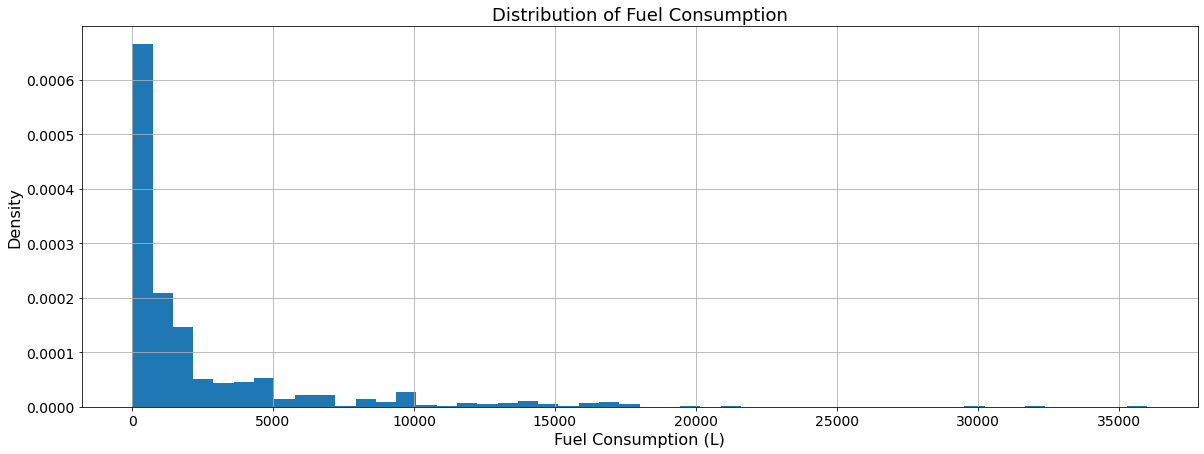

In [4]:
df.FUEL_CONSUMPTION.hist(bins=50, density=True, figsize=(20, 7))
plt.title('Distribution of Fuel Consumption', fontsize=18)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Fuel Consumption (L)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

It's clear we have a highly skewed distribution. Ships consuming a lot more fuel are distributed along a big tail and are a minority. We need to handle this with a mathematical transformation in order to better expose predictive patterns to our models.

Let's try implementing a logarithmic transformation.

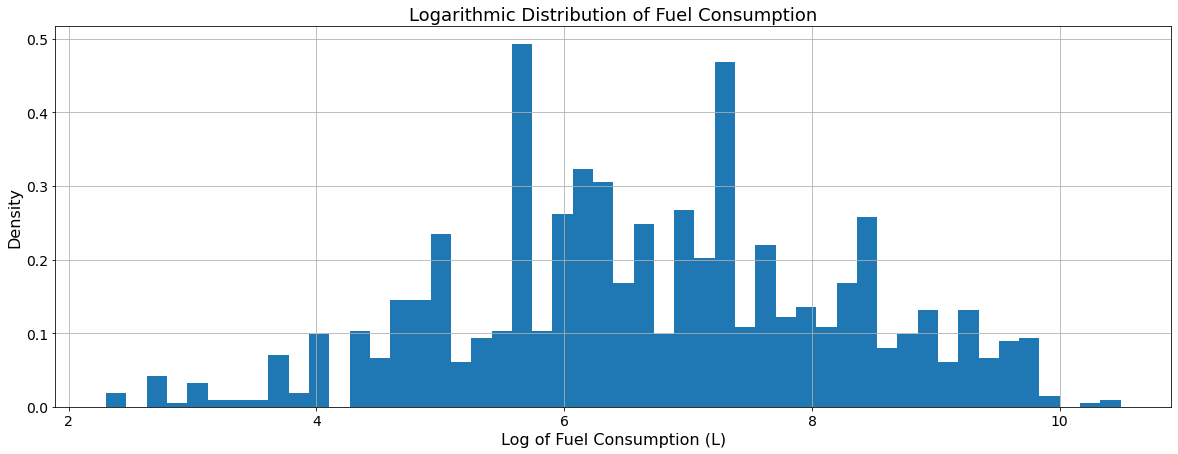

In [5]:
np.log(df.FUEL_CONSUMPTION).hist(bins=50, density=True, figsize=(20, 7))
plt.title('Logarithmic Distribution of Fuel Consumption', fontsize=18)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Log of Fuel Consumption (L)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Now the target distribution looks much more Gaussian than skewed.

## Relationship Between Missing Data and Target Variable
Now let's analyze how missing data impacts on the target column. To do this we'll create an interim variable that indicates 1 if the observation is missing or 0 if not. We'll wrappe this in a function.

Let's analyze TPB first, and then LIGHT_DISPLACEMENT.

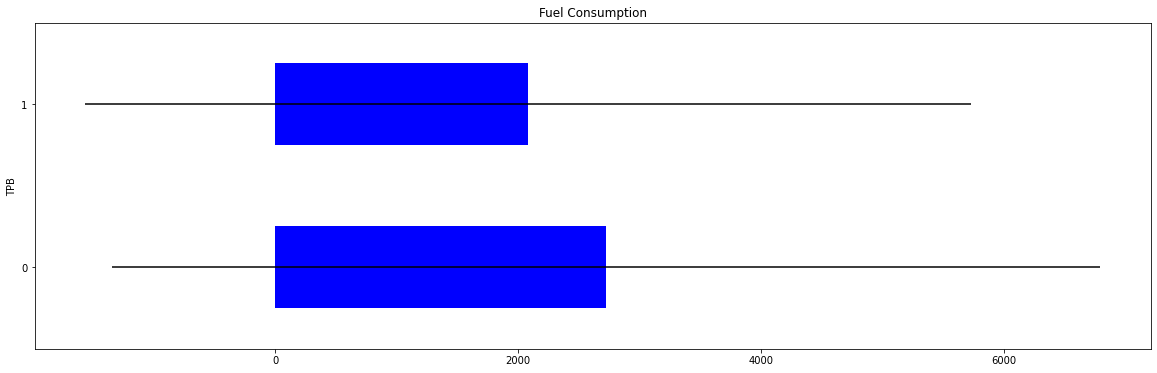

In [6]:
na_impact_analysis(df, 'TPB')

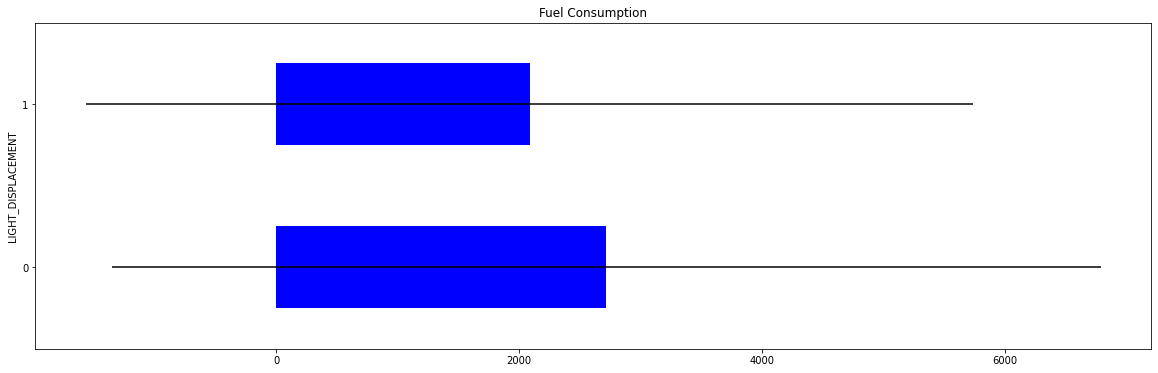

In [7]:
na_impact_analysis(df, 'LIGHT_DISPLACEMENT')

The two variables analyzed above seems to have missing data for the same rows in the database. Also, the average fuel consumption for ships where the information is missing differs from ships that has TPB and LIGHT_DISPLACEMENT. This suggests that the missing value, if handled, could be a good predictor of fuel consumption.

## Analyzing Discrete Variables
Here I'll be analyzing the relationship between discrete variables and the target variable.

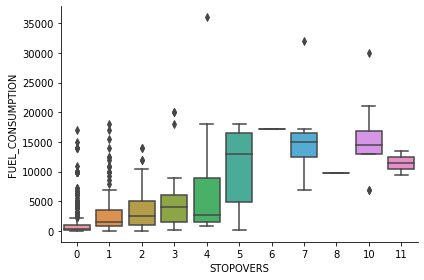

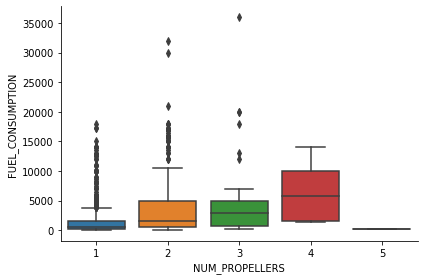

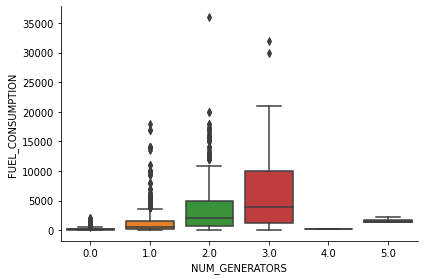

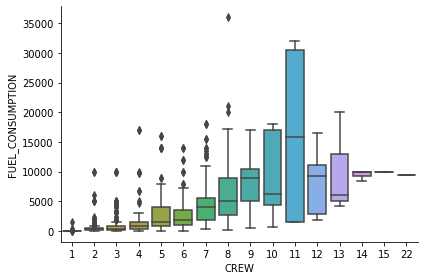

In [16]:
# discrete variables with fewer unique values (easy to analyze)
for disc_var in ['STOPOVERS', 'NUM_PROPELLERS', 'NUM_GENERATORS', 'CREW']:
    sns.catplot(
        x=disc_var, 
        y='FUEL_CONSUMPTION', 
        data=df, 
        kind='box',
        height=4,
        aspect=1.5
    )

Most of the discrete variables analyzed above seems to have a somewhat good predictive pattern, once each of them shows an increase in fuel consumption as the variables itself got increased.

## Analyzing Continuous Variables
Here I'll be analyzing the relationships between continuos variables and the fuel consumption column.

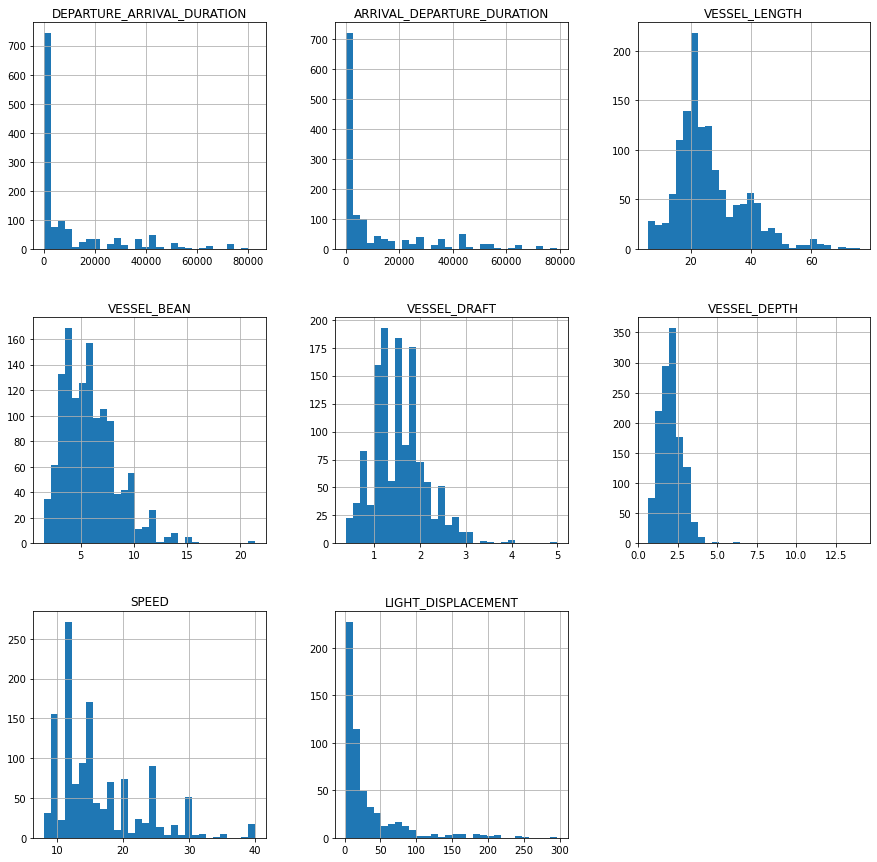

In [19]:
df[continuous_variables[0:-1]].hist(bins=30, figsize=(15, 15))
plt.show()

All of the variables shown above are, more or less, skewed. In situations such as this one we can apply a Yeo-Johnson transformation in the variables and then compare its relationship with the target column, in contrast with their original form.

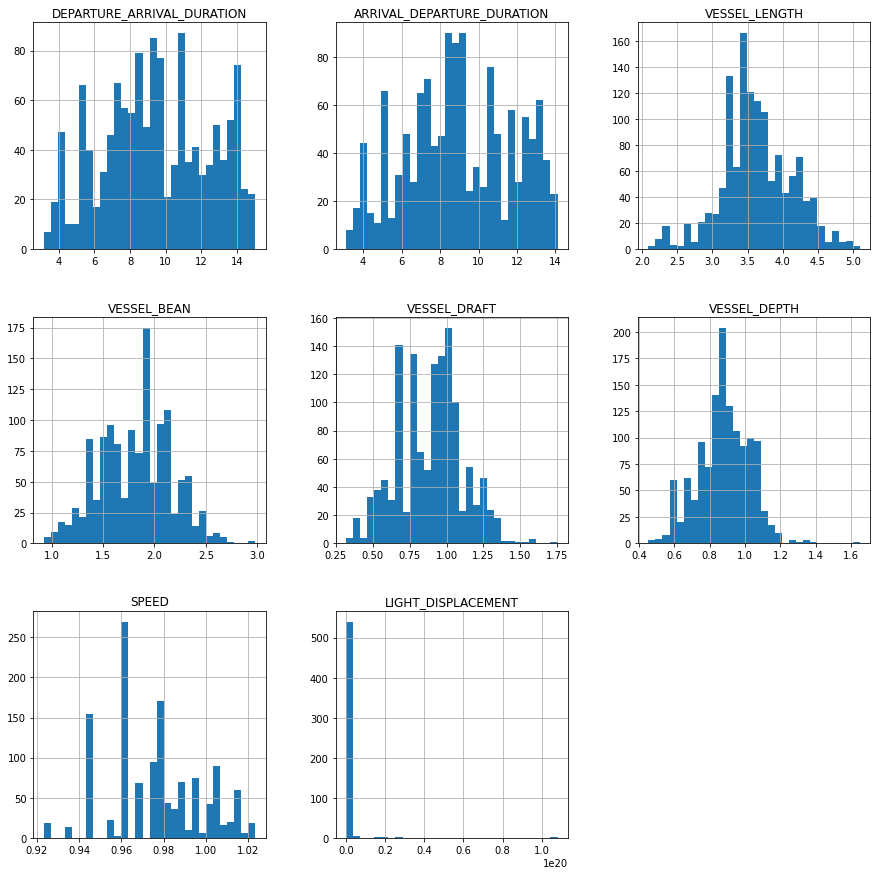

In [23]:
# applying yeo-johnson mathematical transformation
tmp_df = df.copy()

for var in continuous_variables[0:-1]:
    tmp_df[var], param = stats.yeojohnson(df[var])
    
# plotting the transformed data
tmp_df[continuous_variables[0:-1]].hist(bins=30, figsize=(15, 15))
plt.show()

We can clearly see that Yeo-Johnson did a good job for most of our skewed variables, but wasn't the best solution for LIGHT_DISPLACEMENT.

Now let's implement a visual exploration of the relationship between these variables and our target column.

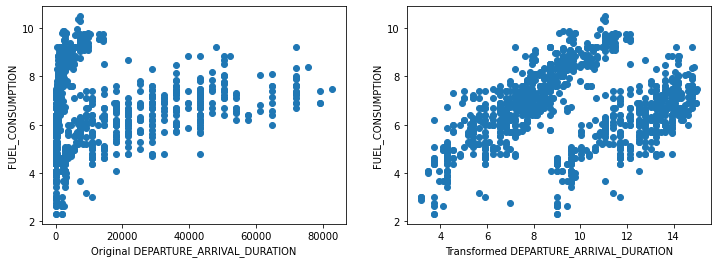

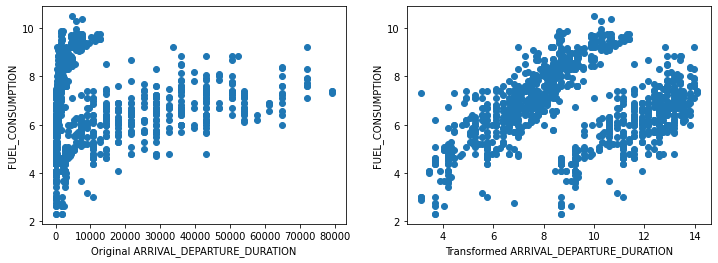

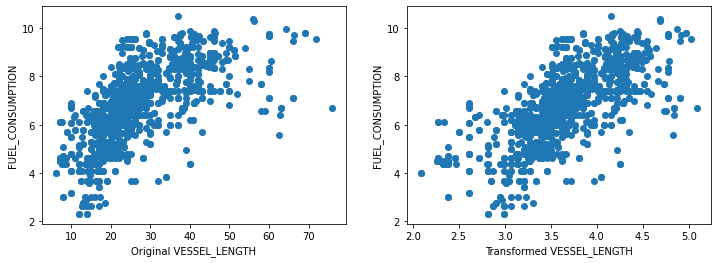

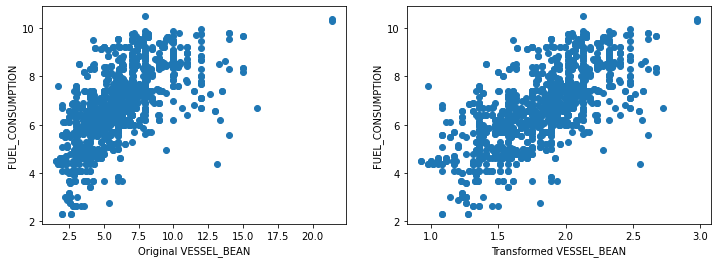

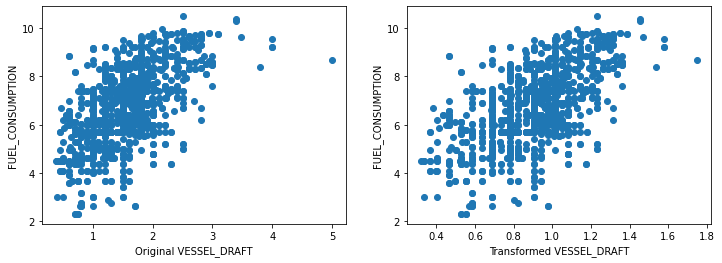

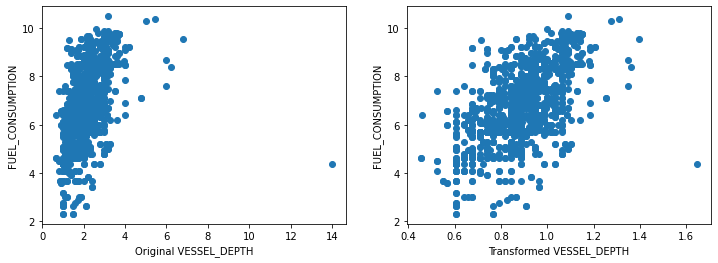

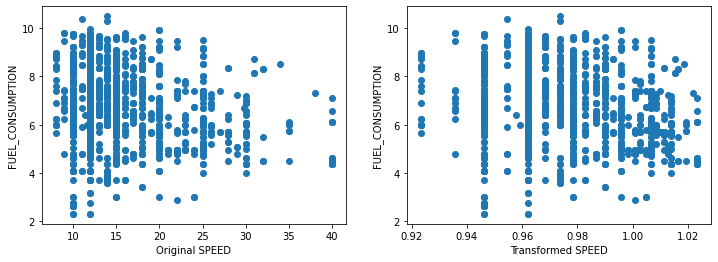

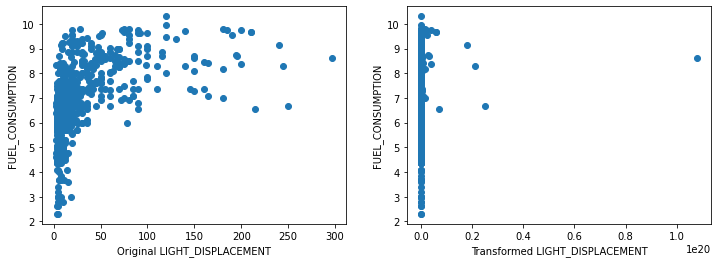

In [25]:
for var in continuous_variables[0:-1]:
    plt.figure(figsize=(12, 4))
    
    # plotting the original skewed data
    plt.subplot(1, 2, 1)
    plt.scatter(df[var], np.log(df['FUEL_CONSUMPTION']))
    plt.xlabel('Original ' + var)
    plt.ylabel('FUEL_CONSUMPTION')
    
    # plotting the transformed data
    plt.subplot(1, 2, 2)
    plt.scatter(tmp_df[var], np.log(tmp_df['FUEL_CONSUMPTION']))
    plt.xlabel('Transformed ' + var)
    plt.ylabel('FUEL_CONSUMPTION')
    
    plt.show()

Some of the variables showed a strongly weak correlation with the target variable in their both original and transformed version. Let's try a different transformation method and then recalculate their relationship with the target column.

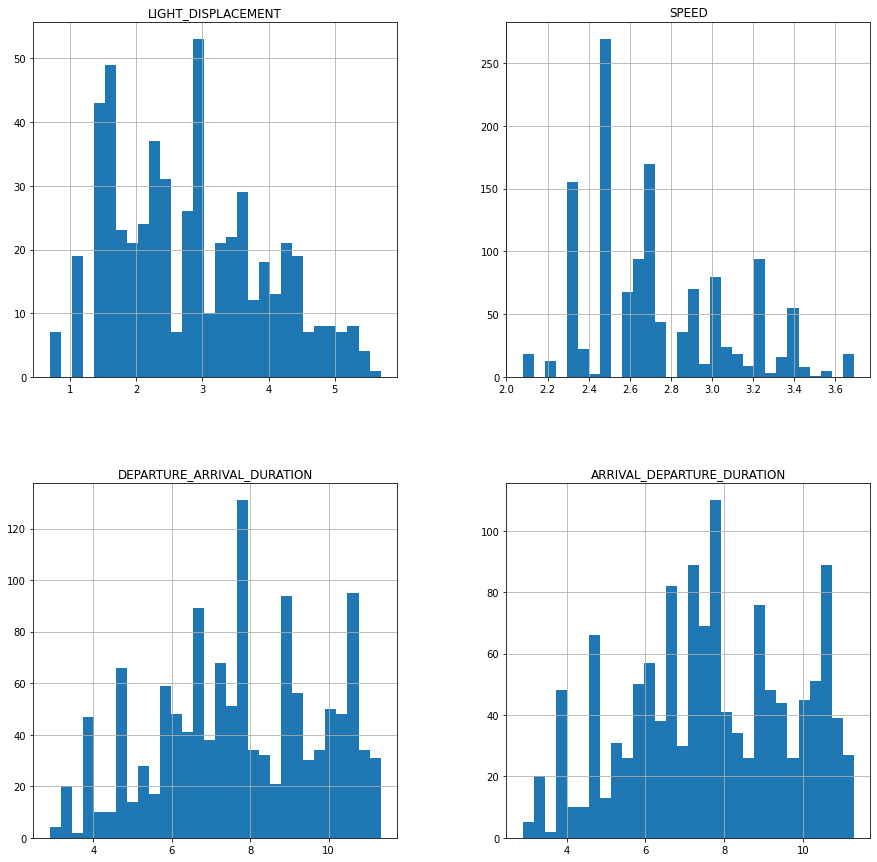

In [32]:
weakly_correlated_vars = ['LIGHT_DISPLACEMENT', 'SPEED', 'DEPARTURE_ARRIVAL_DURATION', 'ARRIVAL_DEPARTURE_DURATION']
tmp_df = df.copy()

for var in weakly_correlated_vars:
    tmp_df[var] = np.log(df[var])

# plotting log transformed variables
tmp_df[weakly_correlated_vars].hist(bins=30, figsize=(15, 15))
plt.show()

Now it seems that we have a more Gaussian-like distribution for these variables. Let's recalculate their relationship with the target variable.

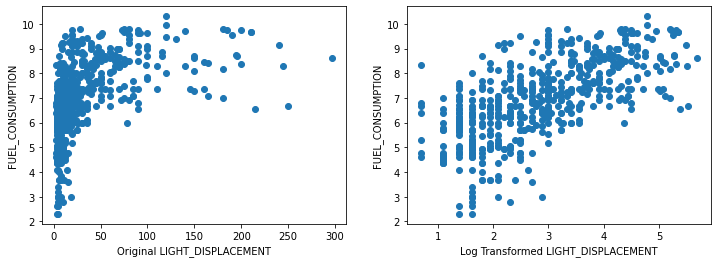

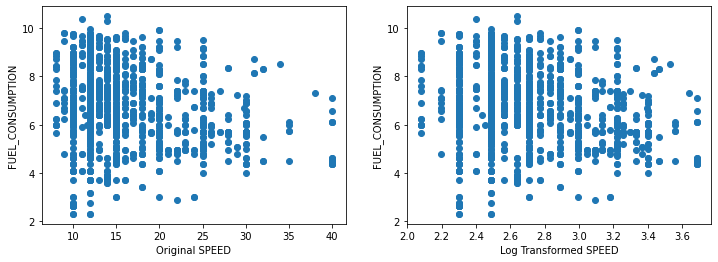

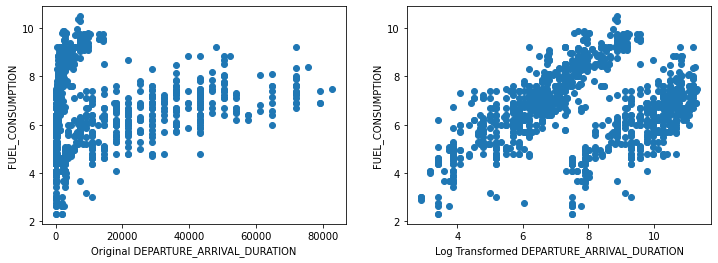

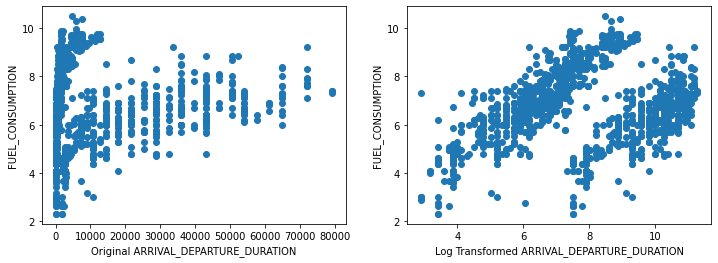

In [33]:
for var in weakly_correlated_vars:
    plt.figure(figsize=(12, 4))
    
    # plotting the original skewed data
    plt.subplot(1, 2, 1)
    plt.scatter(df[var], np.log(df['FUEL_CONSUMPTION']))
    plt.xlabel('Original ' + var)
    plt.ylabel('FUEL_CONSUMPTION')
    
    # plotting the transformed data
    plt.subplot(1, 2, 2)
    plt.scatter(tmp_df[var], np.log(tmp_df['FUEL_CONSUMPTION']))
    plt.xlabel('Log Transformed ' + var)
    plt.ylabel('FUEL_CONSUMPTION')
    
    plt.show()

We can identify an improvement in the relationship of the LIGHT_DISPLACEMENT variable with FUEL_CONSUMPTION, but we can't see the same improvement on the remaining skewed variables, once they doesn't show a strong linear relationship with our target column. This pattern (or lack of one) might indicate that these variables aren't good predictors of FUEL_CONSUMPTION, but we can double-check this in the feature engineering phase.

## Labels Distribution Analysis
Now let's analyze how the frequency of categorical data (with labels) is distributed in our dataset. We can do this for two columns, VESSEL_TYPE and HULL_MATERIAL.

In [38]:
for var in categorical_variables:
    print(analyze_rare_labels(df, [var]))

VESSEL_TYPE
CATAMARAN    0.008
Name: FUEL_CONSUMPTION, dtype: float64
Series([], Name: FUEL_CONSUMPTION, dtype: float64)


Under-represented labels (less than 1% of all observations in a column) tend to overfit machine learning models, so we need to remove them. In such case, by 'removing' I mean to reallocate them under a more representative label, such as the 'OTHER' label.

In [46]:
# reallocating the rare label to 'OTHER'
df.VESSEL_TYPE = df.VESSEL_TYPE.map(lambda x: x.replace('CATAMARAN', 'OTHER'))
df.VESSEL_TYPE.value_counts()

PASSENGER/GENERAL_LOAD    738
MOTORBOAT                 270
FERRY_BOAT                114
PASSENGERS                 98
FLAT_BOTTOMED_BOAT         50
OTHER                      32
Name: VESSEL_TYPE, dtype: int64

Now, after modifying the VESSEL_TYPE column, let's calculate it's relationship with the target column.

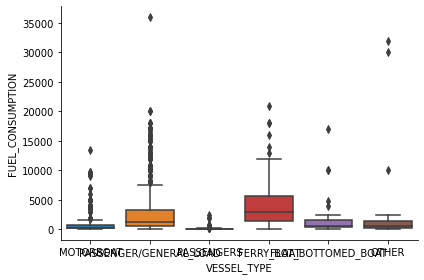

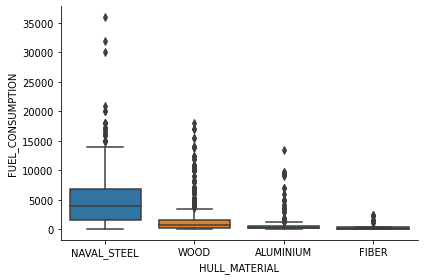

In [55]:
for var in ['VESSEL_TYPE', 'HULL_MATERIAL']:
    sns.catplot(x=var, y='FUEL_CONSUMPTION', data=df, kind='box', height=4, aspect=1.5)
    plt.show()

Although slightly, the two variables analyzed above shows different medians across their labels, which means that they can serve the model well in terms of predictive patterns.